In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import time
import os

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

In [2]:
seed = 42
os.environ['PYTHONHASSEED'] = str(seed)
np.random.seed(seed)

In [3]:
filename = '../data/turbofan_dataset/N-CMAPSS_DS02-006.h5'
output_path = 'DS02'
# filename = '../data/turbofan_dataset/N-CMAPSS_DS04.h5'
# output_path = 'DS04'

In [4]:
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [5]:
def load_dataset(filename):
    """ Reads a dataset from a given .h5 file and compose (in memory) the train and test data. 
    Args:
        filename(str): path to the .h5 file
    Returns:
        train_set(pd.DataFrame), test_set(pd.DataFrame)
    """
    with h5py.File(filename, 'r') as hdf:
        # Development set
        W_dev = np.array(hdf.get('W_dev'))             # W
        X_s_dev = np.array(hdf.get('X_s_dev'))         # X_s
        X_v_dev = np.array(hdf.get('X_v_dev'))         # X_v
        T_dev = np.array(hdf.get('T_dev'))             # T
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # Test set
        W_test = np.array(hdf.get('W_test'))           # W
        X_s_test = np.array(hdf.get('X_s_test'))       # X_s
        X_v_test = np.array(hdf.get('X_v_test'))       # X_v
        T_test = np.array(hdf.get('T_test'))           # T
        Y_test = np.array(hdf.get('Y_test'))           # RUL  
        A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        columns = []
        columns += list(np.array(A_var, dtype='U20'))
        columns += list(np.array(T_var, dtype='U20'))
        columns += list(np.array(X_s_var, dtype='U20'))
        columns += list(np.array(X_v_var, dtype='U20'))
        columns += list(np.array(W_var, dtype='U20'))
        columns += ['RUL']
        
    train_set = np.concatenate((A_dev, T_dev, X_s_dev, X_v_dev, W_dev, Y_dev), axis=1)
    test_set = np.concatenate((A_test, T_test, X_s_test, X_v_test, W_test, Y_test), axis=1)
    
    return pd.DataFrame(data=train_set, columns=columns), pd.DataFrame(data=test_set, columns=columns)

In [6]:
start_time = time.process_time()  
train_set, test_set = load_dataset(filename)
print('')
print("Operation time (sec): " , (time.process_time() - start_time))
print('')
print ("Train set shape: " + str(train_set.shape))
print ("Test set shape: " + str(test_set.shape))


Operation time (sec):  3.828125

Train set shape: (5263447, 47)
Test set shape: (1253743, 47)


In [7]:
def print_unit_cycle_info(df):
    unit_ids = np.unique(df['unit'])
    print('Engine units in df: ', unit_ids)
    for i in unit_ids:
        num_cycles = len(np.unique(df.loc[df['unit'] == i, 'cycle']))
        print('Unit: ', i, ' - Number of flight cycles: ', num_cycles)
        
    cycle_ids = np.unique(df['cycle'])
    print('Total number of cycles: ', len(cycle_ids))
    min_len = np.inf
    max_len = 0
    for i in cycle_ids:
        cycle_len = len(df.loc[df['cycle'] == i, 'cycle'])
        if cycle_len < min_len:
            min_len = cycle_len
        elif cycle_len > max_len:
            max_len = cycle_len
    print('Min cycle length: ', min_len)
    print('Max cycle length: ', max_len)

In [8]:
x_train, y_train = train_set.iloc[:, :-1], train_set.iloc[:, -1]
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.33, shuffle=False)

In [9]:
x_train.shape

(3526509, 46)

In [10]:
# Filter constant and quasi-constant features
def get_quasi_constant_features(dataset, variance_th=0.01, debug=True):
    constant_filter = VarianceThreshold(threshold=variance_th)
    constant_filter.fit(dataset)
    constant_features = [col for col in dataset.columns 
                         if col not in dataset.columns[constant_filter.get_support()]]
    
    if debug:
        print("Number of non-constant features: ", len(dataset.columns[constant_filter.get_support()]))
        
        print("Number of quasi-constant features: ", len(constant_features))
        print("Quasi-constant features: ")
        for col in constant_features:
            print(col)
    return constant_features

def get_non_correlated_features(dataset, corr_th=0.9, debug=True):
    corr_mat = dataset.corr()
    corr_mat = np.abs(corr_mat)
    
    N = corr_mat.shape[0]
    columns = np.full((N,), True, dtype=bool)
    for i in range(N):
        for j in range(i+1, N):
            if corr_mat.iloc[i, j] >= corr_th:
                if columns[j]:
                    columns[j] = False
    if debug:        
        correlated_features = dataset.columns[~columns]
        print("Number of correlated features: ", len(correlated_features))
        print("Correlated features: ")
        for col in correlated_features:
            print(col)
    
    selected_columns = dataset.columns[columns]
    return selected_columns

In [11]:
constant_features = get_quasi_constant_features(x_train)
x_train.drop(labels=constant_features, axis=1, inplace=True)
x_valid.drop(labels=constant_features, axis=1, inplace=True)
print("New shape: ", x_train.shape)

Number of non-constant features:  34
Number of quasi-constant features:  12
Quasi-constant features: 
Fc
fan_eff_mod
fan_flow_mod
LPC_eff_mod
LPC_flow_mod
HPC_eff_mod
HPC_flow_mod
HPT_eff_mod
HPT_flow_mod
LPT_eff_mod
LPT_flow_mod
Mach
New shape:  (3526509, 34)


In [12]:
# Remove highly correlated features
selected_columns = get_non_correlated_features(x_train)
x_train = x_train[selected_columns]
x_valid = x_valid[selected_columns]
print("New shape: ", x_train.shape)

Number of correlated features:  26
Correlated features: 
T48
T50
P2
P21
P24
Ps30
P40
P50
Nf
Nc
Wf
T40
P30
P45
W21
W22
W25
W31
W32
W48
W50
SmHPC
phi
alt
TRA
T2
New shape:  (3526509, 8)


In [13]:
# Drop auxiliary data columns
auxiliary_columns = ['cycle', 'hs', 'Fc']
x_train.drop(labels=[x for x in auxiliary_columns if x in x_train.columns], axis=1, inplace=True)
x_valid.drop(labels=[x for x in auxiliary_columns if x in x_valid.columns], axis=1, inplace=True)

In [15]:
# Time window processing
def time_window_processing(X, y, column_names, unit_ids, window_size):
    df = pd.concat([X, y], axis=1)
    lag_columns = []
    
    for col_name in column_names:
        for i in range(1, window_size):
            partial_columns = []
            for j in range(len(unit_ids)):
                unit_df = df.loc[df['unit'] == unit_ids[j], :]
                col = unit_df[col_name].shift(i)
                col.name = '{}(t-{})'.format(col_name, i)
                partial_columns.append(col)
            column = pd.concat(partial_columns)
            lag_columns.append(column)
    
    df = pd.concat([df] + lag_columns, axis=1)
    df.dropna(inplace=True)
    df.drop(labels=['unit'], axis=1, inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    feature_columns = [col for col in df.columns.values if col != 'RUL']    
    return df[feature_columns], df['RUL']

In [16]:
W = 10
col_names = [col for col in x_train.columns if col != 'unit']
train_unit_ids = np.unique(x_train['unit'])
valid_unit_ids = np.unique(x_valid['unit'])
print('Columns: ', col_names)
print('Unit ids (train): ', train_unit_ids)
print('Unit ids (validation): ', valid_unit_ids)

Columns:  ['T24', 'T30', 'P15', 'SmFan', 'SmLPC']
Unit ids (train):  [ 2.  5. 10. 16.]
Unit ids (validation):  [16. 18. 20.]


In [17]:
x_train_tw, y_train_tw = time_window_processing(x_train, y_train, col_names, train_unit_ids, W)
x_valid_tw, y_valid_tw = time_window_processing(x_valid, y_valid, col_names, valid_unit_ids, W)

In [19]:
def apply_pca(dataset, explained_variance=0.99, scaling=True):
    if scaling:
        scaler = StandardScaler()
        X = scaler.fit_transform(dataset)
    else:
        X = dataset
        
    pca = PCA(0.99, svd_solver='auto', random_state=42)
    X_pca = pca.fit_transform(X)
    return X_pca

In [20]:
x_train_pca = apply_pca(x_train_tw)
x_valid_pca = apply_pca(x_valid_tw)

In [21]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train_pca)
X_test_scaled = scaler.transform(x_valid_pca)

In [62]:
from sklearn.neural_network import MLPRegressor

model = MLPRegressor(hidden_layer_sizes=(20,),
                     activation='relu',
                     solver='adam',
                     early_stopping=False,
                     shuffle=True,
                     max_iter=250,
                     tol=1e-3,
                     random_state=0,
                     verbose=True)

In [63]:
model.fit(x_train, y_train)

Iteration 1, loss = 226.85315841
Iteration 2, loss = 165.66564964
Iteration 3, loss = 157.66651302
Iteration 4, loss = 155.39671280
Iteration 5, loss = 154.47727948
Iteration 6, loss = 154.28183814
Iteration 7, loss = 153.62661170
Iteration 8, loss = 153.21996934
Iteration 9, loss = 153.02217652
Iteration 10, loss = 152.89768739
Iteration 11, loss = 152.82406122
Iteration 12, loss = 152.54384856
Iteration 13, loss = 152.48321599
Iteration 14, loss = 152.35034827
Iteration 15, loss = 152.24281478
Iteration 16, loss = 152.13547342
Iteration 17, loss = 151.96687873
Iteration 18, loss = 151.90180176
Iteration 19, loss = 151.78370855
Iteration 20, loss = 151.72692009
Iteration 21, loss = 151.69609065
Iteration 22, loss = 151.61766408
Iteration 23, loss = 151.63026135
Iteration 24, loss = 151.47090878
Iteration 25, loss = 151.25176319
Iteration 26, loss = 151.31148699
Iteration 27, loss = 151.23900306
Iteration 28, loss = 151.12678354
Iteration 29, loss = 150.99877159
Iteration 30, loss = 15

D:\Anaconda\envs\py38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=(20,), max_iter=150, random_state=0, tol=0.001,
             verbose=True)

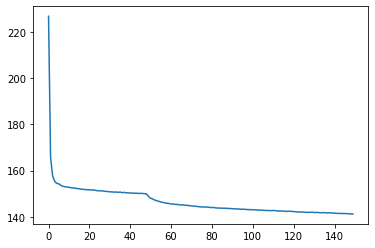

In [64]:
plt.plot(model.loss_curve_)

In [66]:
predictions_train = model.predict(x_train)
predictions_test = model.predict(x_valid)

In [96]:
def cmapss_score_function(actual, predictions):
    diff = actual - predictions
    alpha = np.full_like(diff, 1/10)
    negative_diff_mask = diff < 0
    alpha[negative_diff_mask] = 1/13
    return np.sum(np.exp(alpha * np.abs(diff)))

def evaluation(actual, predictions, label='Test'):
    mse = mean_squared_error(actual, predictions)
    rmse = np.sqrt(mse)
    cmapss_score = cmapss_score_function(actual, predictions)
    variance = r2_score(actual, predictions)
    print('{} set:\nMSE: {}\nRMSE: {}\nCMAPSS score: {}\nR2: {}'.format(label, mse, rmse, cmapss_score, variance))

In [97]:
evaluation(predictions_train, y_train, 'Train')

Train set:
MSE: 279.24682285060373
RMSE: 16.710679903899894
CMAPSS score: 17724807.653319716
R2: -0.2098309350415739


In [99]:
evaluation(predictions_test, y_valid)

Test set:
MSE: 446.6608328260515
RMSE: 21.134351961346045
CMAPSS score: 24764587.323494986
R2: -2.324797211307641


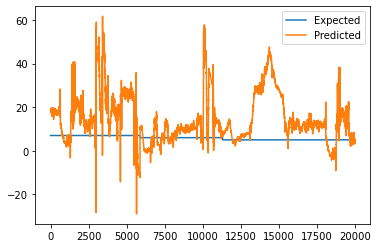

In [76]:
expected = y_valid[:20000]
predicted = predictions_test[:20000]

plt.plot(range(len(expected)), expected, label='Expected')
plt.plot(range(len(predicted)), predicted, label='Predicted')
plt.legend()

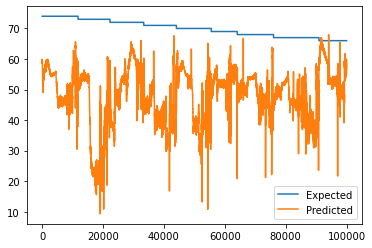

In [80]:
expected = y_train[:10**5]
predicted = predictions_train[:10**5]

plt.plot(range(len(expected)), expected, label='Expected')
plt.plot(range(len(predicted)), predicted, label='Predicted')
plt.legend()

In [34]:
predictions_train = model.predict(X_train_scaled)
mse_train = mean_squared_error(predictions_train, y_train_tw)
mse_train

87.86539729375056

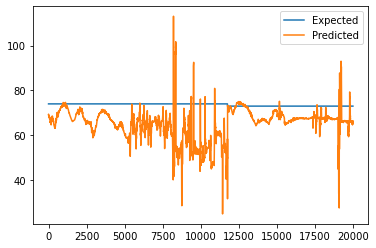

In [35]:
plt.plot(y_train_tw[:20000], label='Expected')
plt.plot(predictions_train[:20000], label='Predicted')
plt.legend()

In [ ]:
from joblib import dump
dump(model, 'mlp.joblib') 

In [100]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(x_train, y_train)

LinearRegression()

In [101]:
y_hat_train = lm.predict(x_train)
y_hat_valid = lm.predict(x_valid)

In [102]:
evaluation(y_train, y_hat_train, 'Train')

Train set:
MSE: 241.43577379127225
RMSE: 15.538203686117397
CMAPSS score: 23424990739.05549
R2: 0.5338720476021973


In [103]:
evaluation(y_valid, y_hat_valid, 'Test')

Test set:
MSE: 441.50257572394503
RMSE: 21.011962681385693
CMAPSS score: 59416803630.40218
R2: -0.03398437863702064


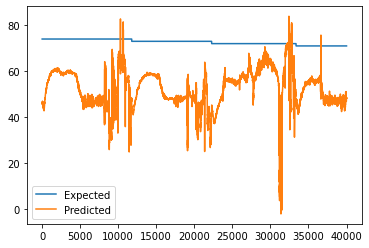

In [58]:
plt.plot(y_train[:40000], label='Expected')
plt.plot(y_hat_train[:40000], label='Predicted')
plt.legend()

In [48]:
x_train.drop(labels=['unit'], axis=1, inplace=True)
x_valid.drop(labels=['unit'], axis=1, inplace=True)

In [59]:
y_hat_train

array([45.8198356 , 45.97216486, 46.4861072 , ..., 11.03258129,
       11.07420235, 11.13825596])

In [60]:
np.mean(y_hat_train)

39.8180254183367

In [61]:
np.mean(y_train)

39.81802541833865